<a href="https://colab.research.google.com/github/diogo0030/computer-vision-classification-of-defects-in-photovoltaic-modules/blob/main/classification_of_defects_in_photovoltaic_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification**

* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** Diogo Soares de Albergaria Oliveira
* **Student Number:** 202108325
---

# **Initial setup**

In [1]:
# Ver informação básica da GPU
!nvidia-smi
# Clonar o repo do dataset
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git

%cd InfraredSolarModules

!unzip 2020-02-14_InfraredSolarModules.zip


Streaming output truncated to the last 5000 lines.
  inflating: InfraredSolarModules/images/2121.jpg  
  inflating: InfraredSolarModules/images/11778.jpg  
  inflating: InfraredSolarModules/images/5896.jpg  
  inflating: InfraredSolarModules/images/4550.jpg  
  inflating: InfraredSolarModules/images/19324.jpg  
  inflating: InfraredSolarModules/images/16017.jpg  
  inflating: InfraredSolarModules/images/10472.jpg  
  inflating: InfraredSolarModules/images/2135.jpg  
  inflating: InfraredSolarModules/images/4.jpg  
  inflating: InfraredSolarModules/images/5882.jpg  
  inflating: InfraredSolarModules/images/19330.jpg  
  inflating: InfraredSolarModules/images/4544.jpg  
  inflating: InfraredSolarModules/images/16003.jpg  
  inflating: InfraredSolarModules/images/12265.jpg  
  inflating: InfraredSolarModules/images/9060.jpg  
  inflating: InfraredSolarModules/images/14614.jpg  
  inflating: InfraredSolarModules/images/6353.jpg  
  inflating: InfraredSolarModules/images/9706.jpg  
  inflat

### **Library Imports**

In [2]:
import os
import math
from pathlib import Path
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from collections import Counter
import math
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from tqdm import tqdm

###Dataset Loading and Initial Exploration
In this section we load and perform an initial exploration of the Infrared Solar Modules dataset provided by Raptor Maps. The dataset consists of infrared (IR) images of photovoltaic (PV) modules, each annotated with a single anomaly type. The annotation file module_metadata.json contains, for every sample, the relative image path (images/<id>.jpg) and the corresponding anomaly_class. We parse this JSON file into a Pandas DataFrame and add an absolute-path column to facilitate subsequent image loading and preprocessing.

In [3]:
data_dir = Path('/content/InfraredSolarModules/InfraredSolarModules')
meta_path = data_dir / 'module_metadata.json'

with open(meta_path, 'r') as f:
    metadata = json.load(f)

df = pd.DataFrame.from_dict(metadata, orient='index')
df = df.rename(columns={'image_filepath': 'rel_path',
                        'anomaly_class': 'label'})

df['path'] = df['rel_path'].apply(lambda p: data_dir / p)
print("Total samples:", len(df))
df.head()

Total samples: 20000


,rel_path,label,path
13357,images/13357.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
13356,images/13356.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
19719,images/19719.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11542,images/11542.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11543,images/11543.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...


###Pre-Processing
Before training our models, we apply a sharpening step to the original infrared images. The Infrared Solar Modules dataset consists of very low–resolution images (24×40 pixels), where defects such as hot-spots or cell cracking often appear as small, low-contrast structures. To enhance these structures, we use an unsharp mask filter, implemented via the PIL.ImageFilter.UnsharpMask function with radius = 2 and strength = 150%.

The unsharp mask computes a blurred version of the image, subtracts it from the original to obtain an “edge image”, and then adds a scaled version of these edges back to the original. Qualitatively, this increases the contrast of cell boundaries and defect regions, as illustrated in Figure (Effect of Unsharp Mask Preprocessing on IR Images).



In [4]:


def apply_unsharp(image, radius=2, percent=150, threshold=0):
    """
    Aplica o filtro UnsharpMask à imagem.
    radius   : raio do blur usado para extrair bordas (2 píxeis, como no artigo)
    percent  : força com que as bordas são somadas de volta (150%)
    threshold: ignora pequenas diferenças (0 = tudo conta)
    """
    return image.filter(ImageFilter.UnsharpMask(radius=radius,
                                               percent=percent,
                                               threshold=threshold))


In [5]:
sharp_dir = Path("/content/IR_dataset_preprocessed")
sharp_dir.mkdir(parents=True, exist_ok=True)

print("\nA aplicar UnsharpMask...")
for img_path in tqdm(df['path'], total=len(df)):
    img_path = Path(img_path)
    dst = sharp_dir / img_path.name

    if dst.exists():
        continue

    img = Image.open(img_path).convert('L')
    sharp = apply_unsharp(img)
    sharp.save(dst)

df['sharp_path'] = df['path'].apply(lambda p: str(sharp_dir / Path(p).name))



A aplicar UnsharpMask...


100%|██████████| 20000/20000 [00:07<00:00, 2575.52it/s]


###Dividing Dataset
The dataset was split into training (80%), validation (10%) and test (10%) sets using stratified sampling to preserve the original class distribution. As shown in Table, the relative frequency of each anomaly class is nearly identical across the three splits

In [6]:
# Copiamos o df só por segurança
full_df = df.copy()

train_df, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df['label'],   # mantém proporção de classes
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
)

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

#test_size=0.2 ficamos com um proporçao de 80/20
#depois dividimos os 20% em metade test_size=0.5
#stratify=... mantem a proporçao


def show_split_stats(name, split_df):
    print(f"\n{name} split ({len(split_df)} samples)")
    counts = split_df['label'].value_counts().sort_index()
    props  = counts / len(split_df) * 100  # percentagem

    stats_df = pd.DataFrame({
        'count': counts,
        'percent': props.round(2)
    })
    print(stats_df)

show_split_stats("Train", train_df)
show_split_stats("Val",   val_df)
show_split_stats("Test",  test_df)


Train: 16000 samples
Val:   2000 samples
Test:  2000 samples

Train split (16000 samples)
                count  percent
label                         
Cell             1502     9.39
Cell-Multi       1030     6.44
Cracking          752     4.70
Diode            1199     7.49
Diode-Multi       140     0.88
Hot-Spot          199     1.24
Hot-Spot-Multi    197     1.23
No-Anomaly       8000    50.00
Offline-Module    662     4.14
Shadowing         845     5.28
Soiling           163     1.02
Vegetation       1311     8.19

Val split (2000 samples)
                count  percent
label                         
Cell              188     9.40
Cell-Multi        129     6.45
Cracking           94     4.70
Diode             150     7.50
Diode-Multi        18     0.90
Hot-Spot           25     1.25
Hot-Spot-Multi     24     1.20
No-Anomaly       1000    50.00
Offline-Module     82     4.10
Shadowing         105     5.25
Soiling            21     1.05
Vegetation        164     8.20

Test split (200

###Data Augmentation

In [7]:
print("Distribuição no train antes da augmentação:")
print(train_df['label'].value_counts())

Distribuição no train antes da augmentação:
label
No-Anomaly        8000
Cell              1502
Vegetation        1311
Diode             1199
Cell-Multi        1030
Shadowing          845
Cracking           752
Offline-Module     662
Hot-Spot           199
Hot-Spot-Multi     197
Soiling            163
Diode-Multi        140
Name: count, dtype: int64


In [8]:

IMG_SIZE = (40, 24)

# Alvo de nº de imagens por classe *no conjunto de treino*
# PODES AJUSTAR ESTES VALORES COMO QUISERES (opção D)
TARGET_PER_CLASS = {
    "Cell":            3000,
    "Cell-Multi":      3000,
    "Cracking":        3000,
    "Diode":           3000,
    "Diode-Multi":     3000,
    "Hot-Spot":        3000,
    "Hot-Spot-Multi":  3000,
    "No-Anomaly":      8000,
    "Offline-Module":  3000,
    "Shadowing":       3000,
    "Soiling":         3000,
    "Vegetation":      3000,
}

augment_dir = Path("/content/IR_dataset_augmented")
augment_dir.mkdir(parents=True, exist_ok=True)

train_transform_offline = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Pad(2, padding_mode='reflect'),
    transforms.RandomCrop(IMG_SIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

aug_rows = []

print("\nA gerar augmentation offline por classe...")

# agrupar o train_df por label (classe)
for label, group in train_df.groupby('label'):
    n_orig = len(group)
    target = TARGET_PER_CLASS.get(label, n_orig)  # se não estiver no dict, não mexe
    n_extra = max(0, target - n_orig)

    print(f"Classe {label}: {n_orig} originais, alvo {target}, precisa de +{n_extra} aug")

    if n_extra == 0:
        continue  # nada a fazer para esta classe

    # repetir as linhas desta classe até ter pelo menos n_extra
    reps = math.ceil(n_extra / n_orig)
    group_rep = pd.concat([group] * reps, ignore_index=True)
    group_rep = group_rep.iloc[:n_extra]  # fica exatamente com n_extra linhas

    # gerar augmentation para cada linha replicada
    for i, row in tqdm(group_rep.iterrows(), total=len(group_rep),
                       desc=f"Augmentando {label}", leave=False):
        img = Image.open(row['sharp_path']).convert('L')

        aug_img = train_transform_offline(img)
        aug_np = np.array(aug_img)
        aug_pil = Image.fromarray(aug_np)

        new_name = f"{Path(row['sharp_path']).stem}_AUG_{i}.png"
        save_path = augment_dir / new_name
        aug_pil.save(save_path)

        aug_rows.append({
            "sharp_path": str(save_path),
            "label": label
        })

# DataFrame com todas as imagens augmentadas
aug_df = pd.DataFrame(aug_rows)
print("\nAugmentations criadas:", len(aug_df))






A gerar augmentation offline por classe...
Classe Cell: 1502 originais, alvo 4000, precisa de +2498 aug


Classe Cell-Multi: 1030 originais, alvo 6000, precisa de +4970 aug


Classe Cracking: 752 originais, alvo 3000, precisa de +2248 aug


Classe Diode: 1199 originais, alvo 3000, precisa de +1801 aug


Classe Diode-Multi: 140 originais, alvo 4000, precisa de +3860 aug


Classe Hot-Spot: 199 originais, alvo 4000, precisa de +3801 aug


Classe Hot-Spot-Multi: 197 originais, alvo 4000, precisa de +3803 aug


Classe No-Anomaly: 8000 originais, alvo 8000, precisa de +0 aug
Classe Offline-Module: 662 originais, alvo 6000, precisa de +5338 aug


Classe Shadowing: 845 originais, alvo 4000, precisa de +3155 aug


Classe Soiling: 163 originais, alvo 8000, precisa de +7837 aug


Classe Vegetation: 1311 originais, alvo 6000, precisa de +4689 aug



Augmentations criadas: 44000


In [9]:
train_final = pd.concat([train_df[['sharp_path', 'label']], aug_df], ignore_index=True)
val_final   = val_df[['sharp_path', 'label']].copy()
test_final  = test_df[['sharp_path', 'label']].copy()

print("\nFinal train size:", len(train_final))
print("Final val size:", len(val_final))
print("Final test size:", len(test_final))

# Ver distribuição final por classe no treino
print("\nContagens por classe no train_final:")
print(train_final['label'].value_counts().sort_index())


Final train size: 60000
Final val size: 2000
Final test size: 2000

Contagens por classe no train_final:
label
Cell              4000
Cell-Multi        6000
Cracking          3000
Diode             3000
Diode-Multi       4000
Hot-Spot          4000
Hot-Spot-Multi    4000
No-Anomaly        8000
Offline-Module    6000
Shadowing         4000
Soiling           8000
Vegetation        6000
Name: count, dtype: int64


In [10]:
class_names = sorted(df['label'].unique())
label2idx = {label: i for i, label in enumerate(class_names)}
idx2label = {i: label for label, i in label2idx.items()}



In [11]:

# AUGMENTATION ONLINE SÓ NO TREINO
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),

    # ---- AUGMENTAÇÃO ONLINE ----
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10, fill=0),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),

    transforms.ToTensor(),
])

# Validação/Teste SEM augmentation
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])


In [12]:
class PVModuleDataset(Dataset):
    def __init__(self, df, label2idx, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['sharp_path']).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.label2idx[row['label']], dtype=torch.long)
        return img, label


In [13]:
train_dataset = PVModuleDataset(train_final, label2idx, train_transform)
val_dataset   = PVModuleDataset(val_final,   label2idx, val_test_transform)
test_dataset  = PVModuleDataset(test_final,  label2idx, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)



###Pre-Check


Batch shape: torch.Size([32, 1, 40, 24])
Labels: tensor([ 6,  1,  8,  3, 11, 10,  0,  7])


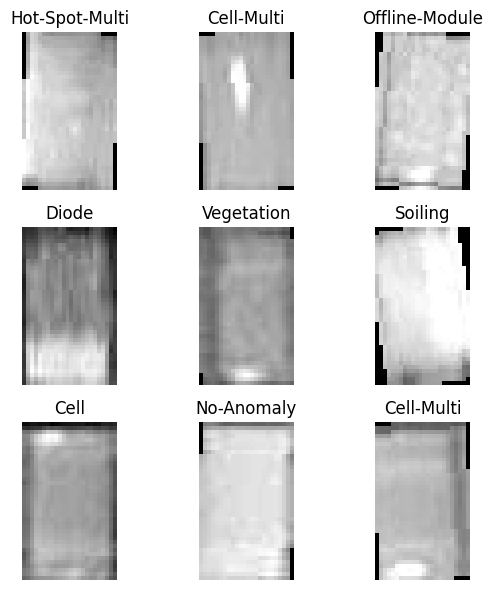

In [14]:
imgs, labels = next(iter(train_loader))
print("\nBatch shape:", imgs.shape)
print("Labels:", labels[:8])

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i][0], cmap='gray')
    plt.title(idx2label[labels[i].item()])
    plt.axis('off')
plt.tight_layout()
plt.show()


The model will be running on cuda:0 device


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 41/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 46/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 51/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 55/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 56/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 57/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 58/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 59/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 60/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 61/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 62/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 63/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 64/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 65/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 66/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 67/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 68/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 69/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 70/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 71/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 72/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 73/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 74/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 75/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 76/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 77/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 78/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 79/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 80/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 81/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 82/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 83/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 84/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 85/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 86/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 87/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 88/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 89/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 90/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 91/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 92/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 93/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 94/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 95/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 96/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 97/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 98/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 99/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 100/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 101/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 102/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 103/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 104/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 105/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 106/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 107/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 108/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 109/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 110/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 111/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 112/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 113/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 114/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 115/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 116/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 117/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 118/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 119/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 120/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 121/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 122/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 123/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 124/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 125/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 126/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 127/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 128/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 129/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 130/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 131/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 132/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 133/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 134/200:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 135/200:   0%|          | 0/1875 [00:00<?, ?it/s]


Early stopping activated!

Finished Training!
Best Epoch: 114, Best Val Acc: 0.8056


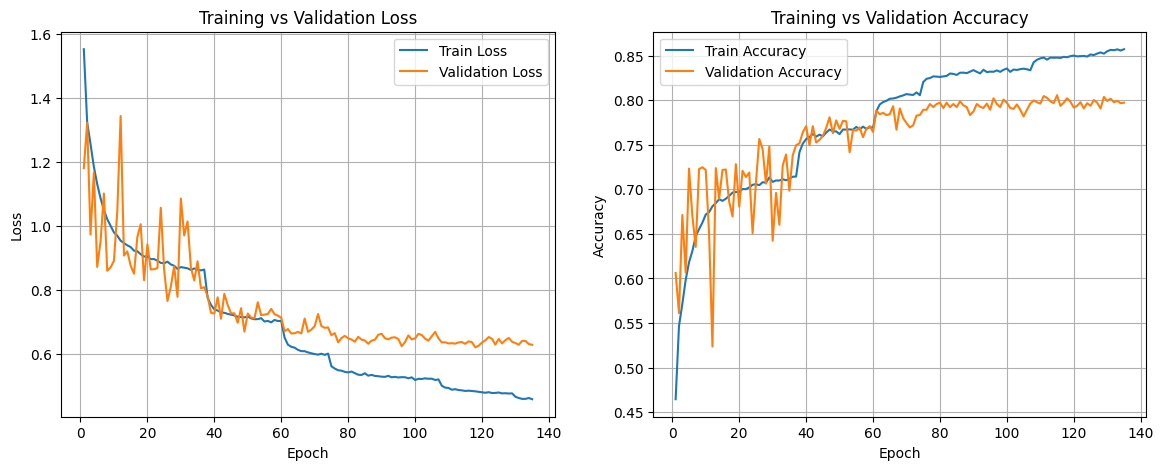

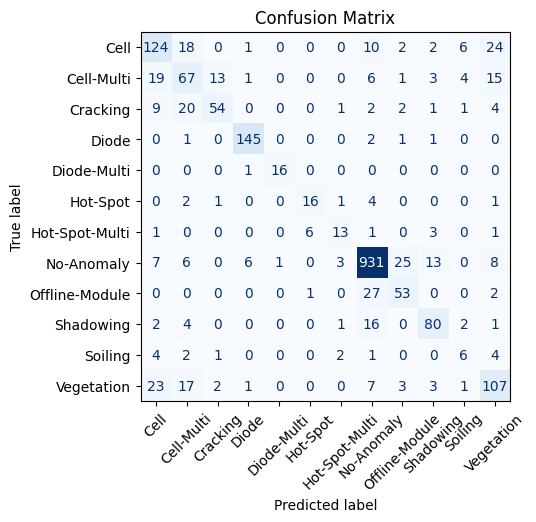


Classification Report:

                precision    recall  f1-score   support

          Cell       0.66      0.66      0.66       187
    Cell-Multi       0.49      0.52      0.50       129
      Cracking       0.76      0.57      0.65        94
         Diode       0.94      0.97      0.95       150
   Diode-Multi       0.94      0.94      0.94        17
      Hot-Spot       0.70      0.64      0.67        25
Hot-Spot-Multi       0.62      0.52      0.57        25
    No-Anomaly       0.92      0.93      0.93      1000
Offline-Module       0.61      0.64      0.62        83
     Shadowing       0.75      0.75      0.75       106
       Soiling       0.30      0.30      0.30        20
    Vegetation       0.64      0.65      0.65       164

      accuracy                           0.81      2000
     macro avg       0.69      0.68      0.68      2000
  weighted avg       0.81      0.81      0.81      2000

Test Loss = 0.6263, Test Accuracy = 0.8051


In [15]:
# ============================================
# 15. DEFINIÇÃO DO MODELO (CNN)
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim import Adam, lr_scheduler

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")


class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # ---- Convolutional Layers ----
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=80, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(80)

        self.conv2 = nn.Conv2d(in_channels=80, out_channels=160, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(160)

        self.conv3 = nn.Conv2d(in_channels=160, out_channels=320, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(320)

        self.conv4 = nn.Conv2d(in_channels=320, out_channels=640, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.batchnorm4 = nn.BatchNorm2d(640)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # ---- Fully Connected ----
        self.fc1 = nn.Linear(in_features=640, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=12)  # 12 classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.batchnorm3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.batchnorm4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ============================================
# 16. FUNÇÕES DE TREINO / TESTE
# ============================================
def saveModel(model: nn.Module, path):
    torch.save(model.state_dict(), path)


def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          val_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim=True):

    model.train()
    model.to(device)

    best_accuracy = 0.0
    best_loss = float('inf')
    best_epoch = 0

    epochs_no_improve_acc = 0
    patience_acc = 20

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # ----------------------
    # LOOP DE EPOCHS
    # ----------------------
    epoch_bar = tqdm(range(num_epochs), desc="Training Epochs")

    for epoch in epoch_bar:

        train_acc = 0.0
        train_loss = 0.0

        # ----------------------
        # LOOP DE BATCHES (com tqdm)
        # ----------------------
        batch_bar = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in batch_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            train_acc += (preds == labels).sum().item() / len(labels)

            # Atualizar barra com info do batch
            batch_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # ----------------------
        # VALIDAÇÃO
        # ----------------------
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                out = model(images)
                loss = loss_fn(out, labels)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # armazenar histórico
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # atualizar descrição da barra principal
        epoch_bar.set_postfix(
            Train_Loss=train_loss,
            Val_Loss=val_loss,
            Train_Acc=train_acc,
            Val_Acc=val_acc
        )

        # scheduler
        scheduler.step(val_loss)

        # guardar melhor modelo
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), path_model)
            epochs_no_improve_acc = 0

        else:
            epochs_no_improve_acc += 1

        if epochs_no_improve_acc >= patience_acc:
            print("\nEarly stopping activated!")
            break

        model.train()

    return (best_loss, best_accuracy, best_epoch,
            train_loss_history, train_acc_history,
            val_loss_history, val_acc_history)



def test(model,
         dataloader,
         loss_fn,
         device,
         verbatim=True):

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    pred_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            y_pred_class = y_pred.argmax(dim=1)
            test_acc += (y_pred_class == labels).sum().item() / len(labels)

            pred_labels.extend(y_pred_class.cpu().tolist())

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    if verbatim:
        print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc


# ============================================
# 17. PLOT CURVAS DE TREINO
# ============================================
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()


# ============================================
# 18. CONFUSION MATRIX + REPORT
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

def evaluate_full(model, testloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))


# ============================================
# 19. MAIN: TREINAR E AVALIAR
# ============================================
# (no Colab podes só correr esta célula, não precisas de if __name__ == "__main__")
model = Network().to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)
(best_loss, best_accuracy, best_epoch,
 train_loss_history, train_acc_history,
 val_loss_history, val_acc_history) = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=200,
    path_model="/content/myModel_best.pth",
    verbatim=True
)

print("\nFinished Training!")
print(f"Best Epoch: {best_epoch}, Best Val Acc: {best_accuracy:.4f}")

plot_training_curves(train_loss_history, val_loss_history,
                     train_acc_history, val_acc_history)

# ---- LOAD BEST MODEL ----
best_model = Network().to(device)
best_model.load_state_dict(torch.load("/content/myModel_best.pth", map_location=device))

# ---- CONFUSION MATRIX + REPORT ----
# usar nomes reais das classes (por ex.: ['Cell', 'Cell-Multi', ...])
evaluate_full(best_model, test_loader, device, class_names)

# ---- TEST METRICS ----
pred, test_loss, test_acc = test(
    best_model,
    dataloader=test_loader,
    loss_fn=loss_fn,
    device=device,
    verbatim=True
)